# Food identification with segmentation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Preprocessing

Creating a function to read image ids



*   Setting target dimensions for images(256,256)
*   Specifing the batch size(16) and the number of classes(104)
*  Creating a function to read image ids
*  Creating a test set from validation set to evaluate the model's segmentation on test set
*   creating function to read images and their masks
*   Creating a Tensorflow dataset (each element of the dataset is a pair of an image and its corresponding mask)







In [ ]:
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt

dataset_dir = '/content/drive/MyDrive/FoodSeg103'

img_height = 256
img_width = 256
batch_size = 16
num_class = 104


def read_image_ids(file_path):

    with open(file_path, 'r') as f:
        image_ids = [line.strip() for line in f if line.strip()]
    return image_ids


train_image_ids = read_image_ids(os.path.join(dataset_dir, 'ImageSets', 'train.txt'))
val_test_ids = read_image_ids(os.path.join(dataset_dir, 'ImageSets', 'test.txt'))

#Creating a test set from the validation set to test the performance of the model
random.shuffle(val_test_ids)
split_point = len(val_test_ids) // 10
test_image_ids = val_test_ids[:split_point]
val_image_ids = val_test_ids[split_point:]


#Creating train/validation/test paths
train_image_paths = [os.path.join(dataset_dir, 'Images', 'img_dir', 'train', f'{os.path.splitext(id)[0]}.jpg')
                     for id in train_image_ids]
train_mask_paths = [os.path.join(dataset_dir, 'Images', 'ann_dir', 'train', f'{os.path.splitext(id)[0]}.png')
                    for id in train_image_ids]

val_image_paths = [os.path.join(dataset_dir, 'Images', 'img_dir', 'test', f'{os.path.splitext(id)[0]}.jpg')
                    for id in val_image_ids]
val_mask_paths = [os.path.join(dataset_dir, 'Images', 'ann_dir', 'test', f'{os.path.splitext(id)[0]}.png')
                    for id in val_image_ids]
test_image_paths = [os.path.join(dataset_dir, 'Images', 'img_dir', 'test', f'{os.path.splitext(id)[0]}.jpg')
                    for id in test_image_ids]
test_mask_paths = [os.path.join(dataset_dir, 'Images', 'ann_dir', 'test', f'{os.path.splitext(id)[0]}.png')
                    for id in test_image_ids]


def load_image_and_mask(image_path, mask_path):

    #image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) #decoding the JPEG image into a tensor with 3 channels (RGB)
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  #normalize to [0, 1]

    #mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # decoding the PNG mask into a tensor with 1 channel (grayscale)
    mask = tf.image.resize(mask, [img_height, img_width], method='nearest')  # using the nearest method to preserve integer labels
    mask = tf.cast(mask, tf.uint8)  # ensuring integer labels

    return image, mask

# Creating a tensorFlow dataset from the lists of image and mask paths. each element is a pair (image_path, mask_path).
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE) #randomly shuffling the dataset to improve training generalization.

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_dataset= test_dataset.map(load_image_and_mask,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# checking the first few paths to ensure they exist
for path in train_image_paths[:5] + train_mask_paths[:5]:
    if not os.path.exists(path):
        print(f"Warning: File not found: {path}")

#testing the dataset
# taking the forst batch of the dataset to check the shape of the images and their corresponding mask
for image, mask in train_dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

Image shape: (16, 256, 256, 3)
Mask shape: (16, 256, 256, 1)


# Architecture
Encoder:

*   4 levels (64, 128, 256, 512 filters) with max pooling to reduce resolution (256x256 → 16x16).
*   
Dropout (0.2) added at levels 2 and 4 for regularization.


Bottleneck:

*   1024 filters at 16x16 resolution, with dilated convolutions (rate=2) and L2 regularization.
*   Dropout (0.2) for regularization.


Decoder:

*   4 levels (512, 256, 128, 64 filters) with upsampling and skip connections from the encoder.
*   Dropout (0.4, 0.3) at deeper decoder levels, L2 regularization at the final level.





Output:

*   A 256x256 segmentation map with 104 class probabilities per pixel.




In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation,Dropout
from tensorflow.keras.regularizers import l2


# U-Net Model
def unet(input_shape=(img_height, img_width, 3), num_classes=num_class,l2_lambda=0.01):

    #creating an input tensor with shape (256, 256, 3)
    inputs = Input(input_shape)

    # Encoder
    # Level 1: 64 filters
    c1 = Conv2D(64, 3, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D()(c1)
    p1 = Dropout(0.1)(p1)

    # Level 2: 128 filters
    c2 = Conv2D(128, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D()(c2)
    p2 = Dropout(0.2)(p2)

    # Level 3: 256 filters
    c3 = Conv2D(256, 3, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, 3, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D()(c3)

    # Level 4: 512 filters
    c4 = Conv2D(512, 3, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(512, 3, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D()(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck: 1024 filters
    c5 = Conv2D(1024, 3, padding='same',dilation_rate=2,kernel_regularizer=l2(l2_lambda))(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(1024, 3, padding='same',dilation_rate=2,kernel_regularizer=l2(l2_lambda))(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.2)(c5)

    # Decoder
    # Level 4: 512 filters
    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c4])  #skip connection from encoder level 4
    c6 = Conv2D(512, 3, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(512, 3, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.4)(c6)

    # Level 3: 256 filters
    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c3])  #skip connection from encoder level 3
    c7 = Conv2D(256, 3, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(256, 3, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.3)(c7)

    # Level 2: 128 filters
    u8 = UpSampling2D()(c7)
    u8 = Concatenate()([u8, c2])  #skip connection from encoder level 2
    c8 = Conv2D(128, 3, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(128, 3, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    # Level 1: 64 filters
    u9 = UpSampling2D()(c8)
    u9 = Concatenate()([u9, c1])  #skip connection from encoder level 1
    c9 = Conv2D(64, 3, padding='same',kernel_regularizer=l2(l2_lambda))(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(64, 3, padding='same',kernel_regularizer=l2(l2_lambda))(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)


    outputs = Conv2D(num_classes, 1, activation='softmax')(c9)
    model = Model(inputs, outputs)

    return model



# Evaluation Metric MeanIoU

In [ ]:
#it wraps TensorFlow's built-in MeanIoU metric, adding preprocessing steps to handle the specific input formats of predicted and ground truth masks

class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_tracker = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # converting probabilities to class indices
        y_true = tf.cast(y_true, tf.int32)   # ensuring integer labels
        if y_true.shape[-1] == 1:            # removing extra dimension if present
            y_true = tf.squeeze(y_true, axis=-1)
        self.iou_tracker.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou_tracker.result()

    def reset_states(self):
        self.iou_tracker.reset_states()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = unet(input_shape=(img_height, img_width, 3), num_classes=num_class)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=num_class)])

learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(train_dataset,epochs=70,validation_data=val_dataset,callbacks=[learning_rate_scheduler])


Epoch 1/70
312/312 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.4447 - loss: 5.0550 - mean_iou: 0.0159 - val_accuracy: 0.4021 - val_loss: 3.0148 - val_mean_iou: 0.0060 - learning_rate: 0.0010
Epoch 2/70
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.5126 - loss: 2.1636 - mean_iou: 0.0207 - val_accuracy: 0.4953 - val_loss: 2.3578 - val_mean_iou: 0.0167 - learning_rate: 0.0010
Epoch 3/70
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.5260 - loss: 2.0802 - mean_iou: 0.0243 - val_accuracy: 0.4884 - val_loss: 2.3089 - val_mean_iou: 0.0193 - learning_rate: 0.0010
Epoch 4/70
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.5311 - loss: 2.0359 - mean_iou: 0.0268 - val_accuracy: 0.5225 - val_loss: 2.1250 - val_mean_iou: 0.0226 - learning_rate: 0.0010
Epoch 5/70
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.5393 - loss: 1.9839 - mean_iou: 0.0286 - val_accuracy: 0.5262 - val_loss: 2.0900 - val_mean_iou: 0.0231 - learning_rate: 0.0010
Epoch 6/70
312/31

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


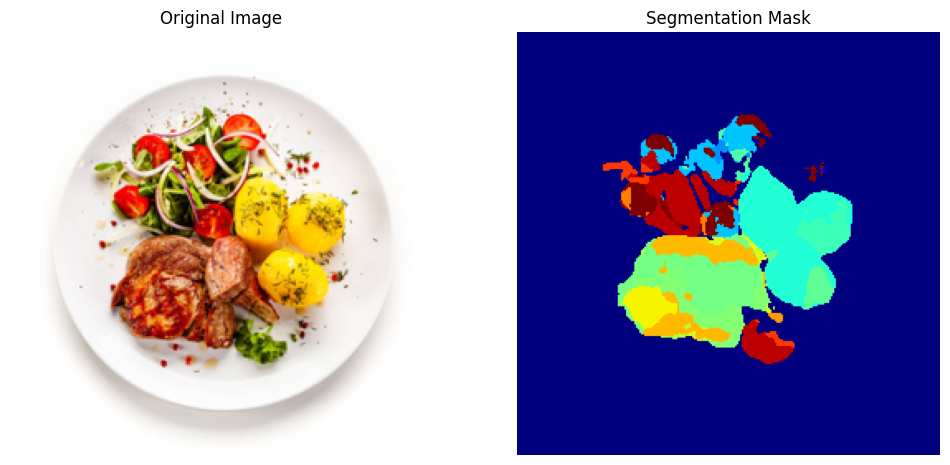

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


img_path = '/content/drive/MyDrive/test2.jpg'
img = Image.open(img_path).resize((256, 256))
img_array = np.array(img) / 255.0

img_input = np.expand_dims(img_array, axis=0)

#predict the segmentation mask
prediction = model.predict(img_input)
mask = np.argmax(prediction, axis=-1)[0]  #shape: (256, 256)


plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='jet')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Overall MeanIoU on test set: 0.1616


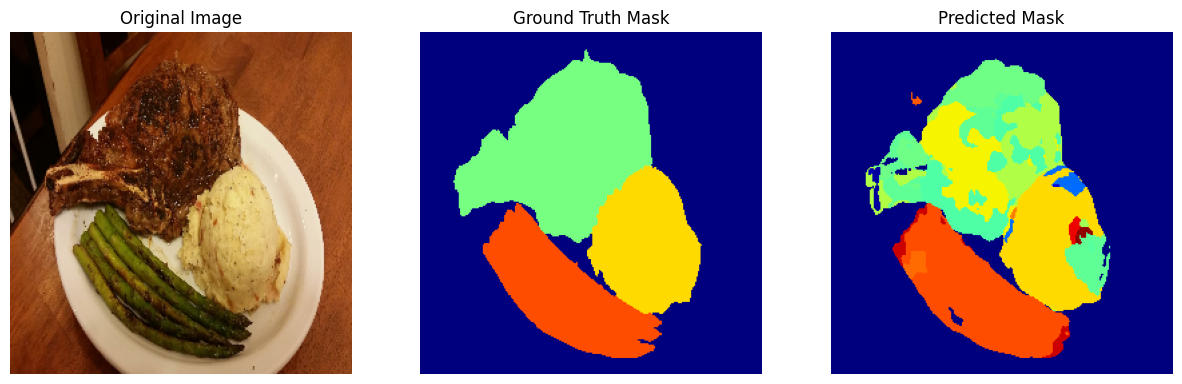

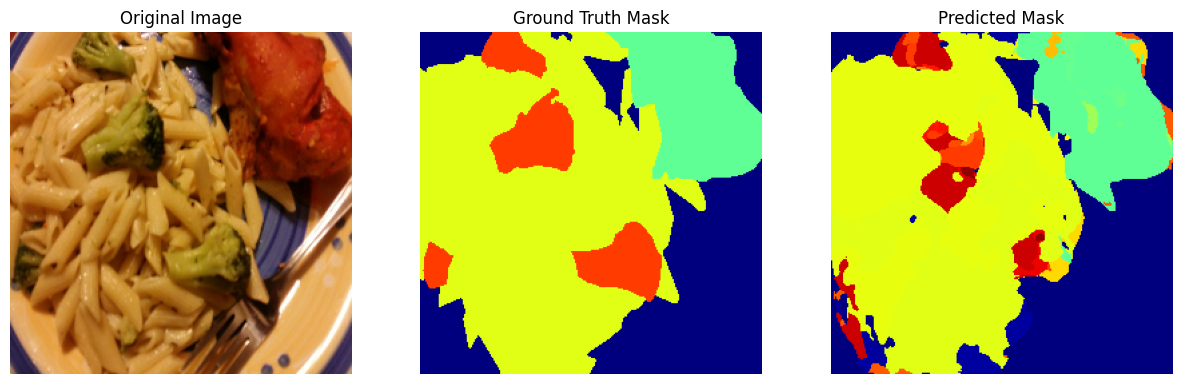

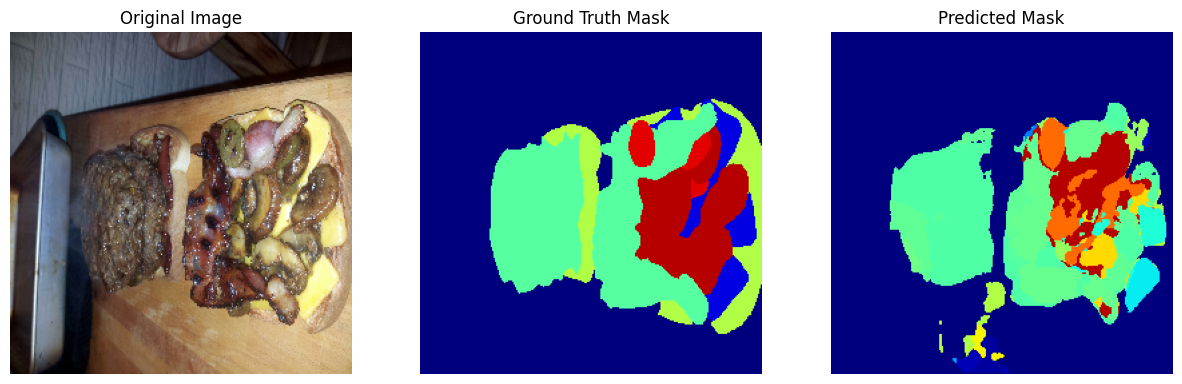

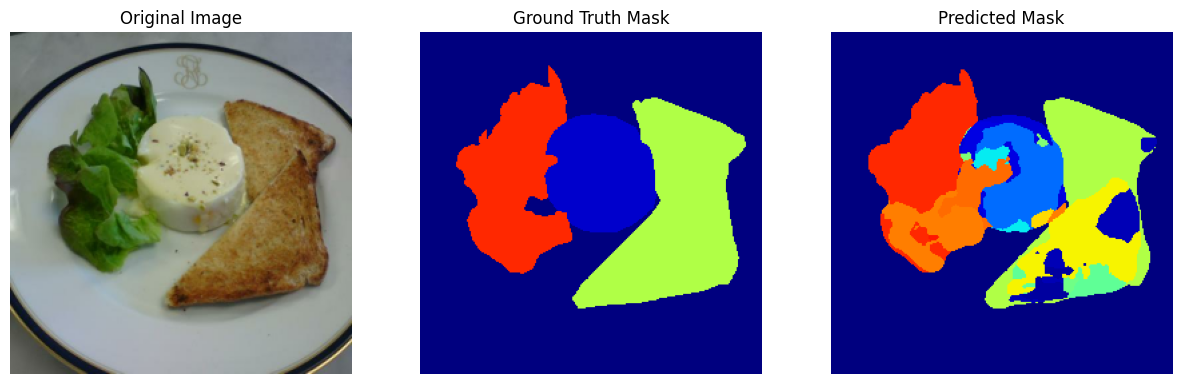

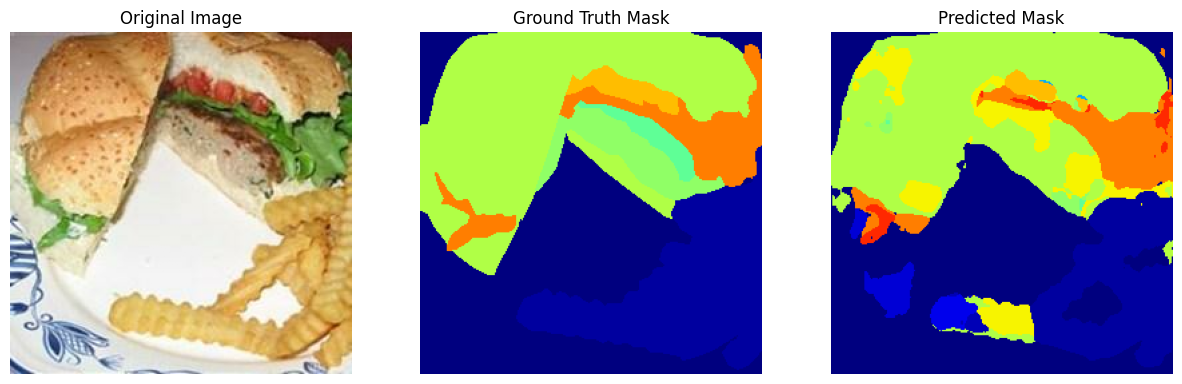

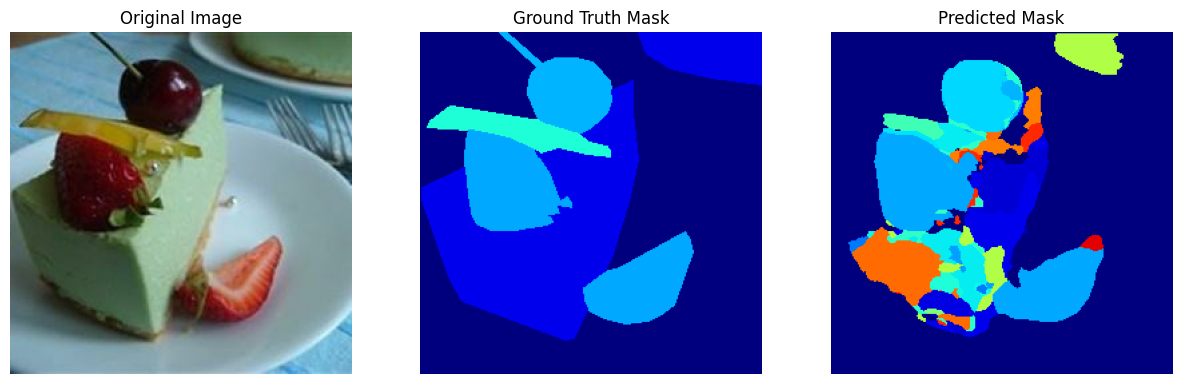

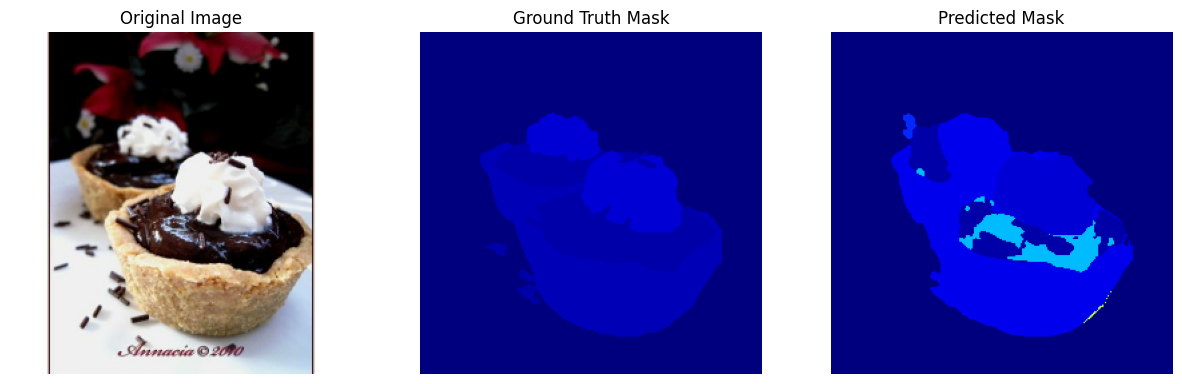

In [ ]:
miou_metric = tf.keras.metrics.MeanIoU(num_classes=num_class)
sample_images = []

for images, masks in test_dataset:

    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=-1)
    miou_metric.update_state(masks, pred_labels)

    if len(sample_images) < 7:
        for i in range(min(7 - len(sample_images), images.shape[0])):
            sample_images.append((images[i], masks[i], pred_labels[i]))

overall_miou = miou_metric.result().numpy()
print(f"Overall MeanIoU on test set: {overall_miou:.4f}")

for i, (img, mask, pred) in enumerate(sample_images):
    img_np = img.numpy()
    mask_np = mask.numpy().squeeze()
    pred_np = pred

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='jet', vmin=0, vmax=num_class-1)
    plt.title("Ground Truth Mask")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_np, cmap='jet', vmin=0, vmax=num_class-1)
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()


# Label Vissualisation

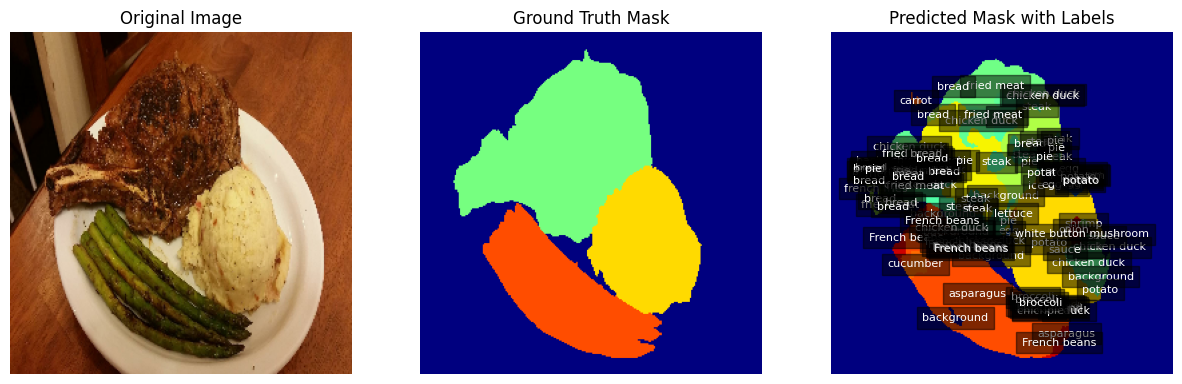

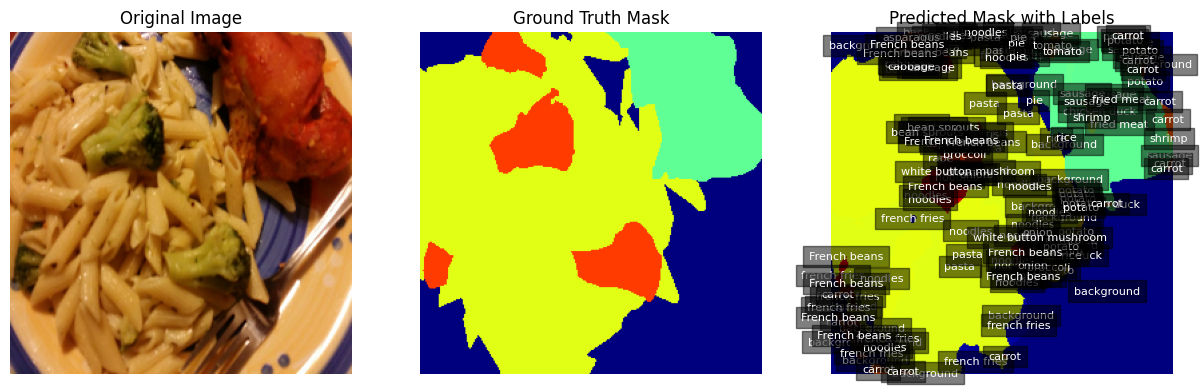

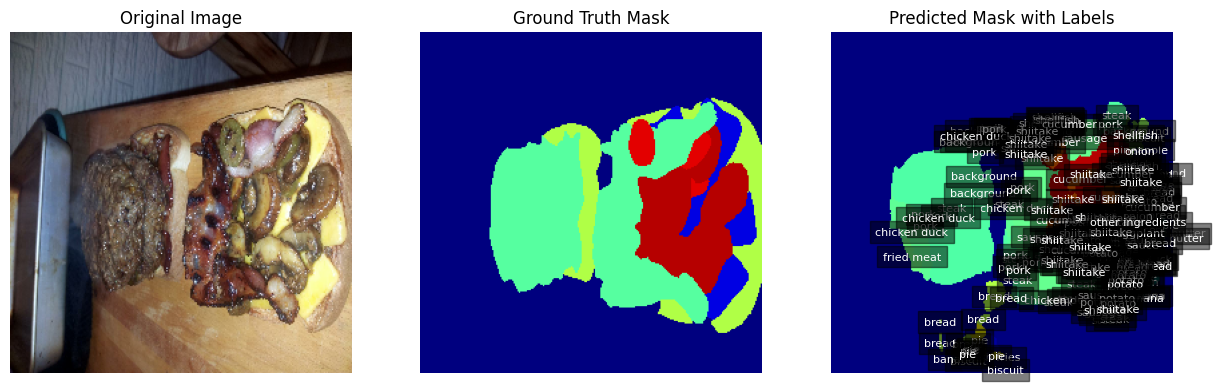

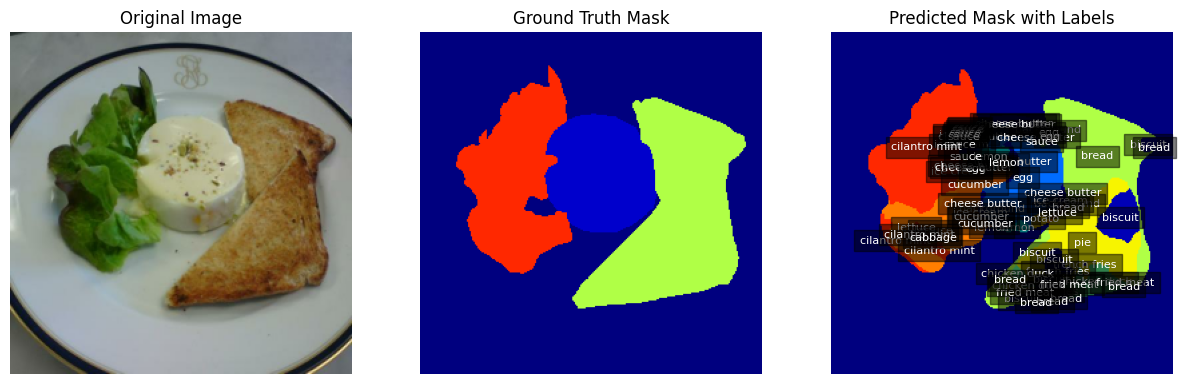

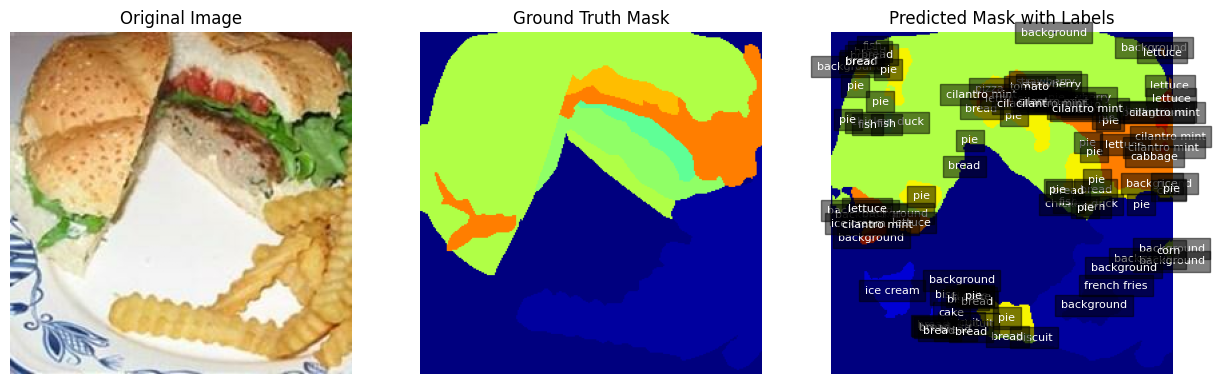

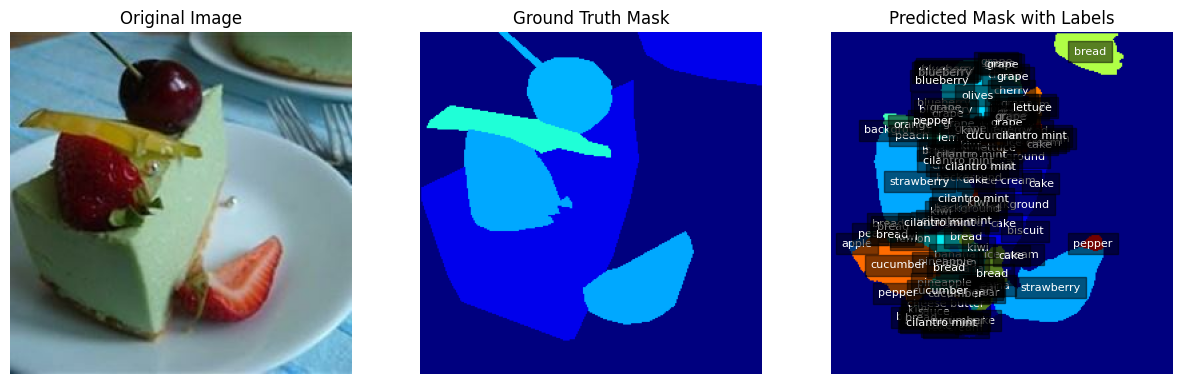

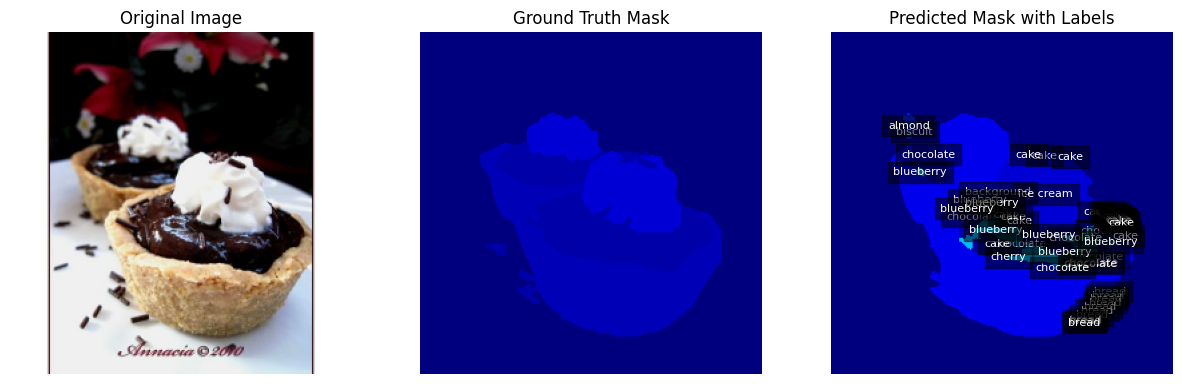

In [ ]:
from scipy.ndimage import label as scipy_label
class_names = [
    "background", "candy", "egg tart", "french fries", "chocolate", "biscuit", "popcorn", "pudding",
    "ice cream", "cheese butter", "cake", "wine", "milkshake", "coffee", "juice", "milk", "tea",
    "almond", "red beans", "cashew", "dried cranberries", "soy", "walnut", "peanut", "egg",
    "apple", "date", "apricot", "avocado", "banana", "strawberry", "cherry", "blueberry",
    "raspberry", "mango", "olives", "peach", "lemon", "pear", "fig", "pineapple", "grape",
    "kiwi", "melon", "orange", "watermelon", "steak", "pork", "chicken duck", "sausage",
    "fried meat", "lamb", "sauce", "crab", "fish", "shellfish", "shrimp", "soup", "bread",
    "corn", "hamburg", "pizza", "hanamaki baozi", "wonton dumplings", "pasta", "noodles",
    "rice", "pie", "tofu", "eggplant", "potato", "garlic", "cauliflower", "tomato", "kelp",
    "seaweed", "spring onion", "rape", "ginger", "okra", "lettuce", "pumpkin", "cucumber",
    "white radish", "carrot", "asparagus", "bamboo shoots", "broccoli", "celery stick",
    "cilantro mint", "snow peas", "cabbage", "bean sprouts", "onion", "pepper", "green beans",
    "French beans", "king oyster mushroom", "shiitake", "enoki mushroom", "oyster mushroom",
    "white button mushroom", "salad", "other ingredients"
]
assert len(class_names) == num_class, "Number of class names must match num_class"

def annotate_mask(mask, ax):
    mask_np = mask
    unique_labels = np.unique(mask_np)
    for label in unique_labels:
        if label < num_class:
            binary_mask = (mask_np == label).astype(np.uint8)
            labeled_array, num_features = scipy_label(binary_mask)
            for region_idx in range(1, num_features + 1):
                region = (labeled_array == region_idx)
                coords = np.where(region)
                centroid_y = np.mean(coords[0])
                centroid_x = np.mean(coords[1])
                class_name = class_names[label]
                ax.text(centroid_x, centroid_y, class_name, color='white', fontsize=8,
                        ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))


for i, (img, mask, pred) in enumerate(sample_images):
    img_np = img.numpy()
    mask_np = mask.numpy().squeeze()
    pred_np = pred.numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='jet', vmin=0, vmax=num_class-1)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    ax = plt.gca()
    plt.imshow(pred_np, cmap='jet', vmin=0, vmax=num_class-1)
    annotate_mask(pred_np, ax)
    plt.title("Predicted Mask with Labels")
    plt.axis('off')

    plt.show()